In [1]:
!pip install mlxtend

In [ ]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('archive')
    

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:

import pandas as pd
dataset = pd.read_csv('archive/archive/fashion-mnist_train.csv')

In [37]:
y = dataset['label']

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    
    def __init__(self, data, transform = None):
        self.fashion_MNIST = data
        self.transform = transform
        
        
        label = []
        image = []
        
        for i in range(len(self.fashion_MNIST)):
            label.append(train.iloc[i, 0])
            image.append(train.iloc[i, 1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
        

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.images)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)


In [41]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [42]:
train_dataset = Dataset(train)
train_loader = DataLoader(train_dataset, batch_size = 25)

In [43]:
test_dataset = Dataset(test)
test_loader = DataLoader(test_dataset, batch_size = 25)

In [44]:
import torch
from torch import nn


class CNN(nn.Module):
    def __init__(self):
            super(CNN, self).__init__()
            self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
            self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
            self.fc1 = nn.Linear(in_features=6*6*64, out_features=512)
            self.fc2 = nn.Linear(in_features=512, out_features=128)
            self.fc3 = nn.Linear(in_features=128, out_features=10)
            

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [72]:
class SimpleMLP(nn.Module):
    def __init__(self, input_shape, list_hidden_layers, output_shape):
        super(SimpleMLP, self).__init__()
        l = []
        l.append(nn.Linear(input_shape, list_hidden_layers[0]))
        nn.BatchNorm2d(list_hidden_layers[0]),
        l.append(nn.ReLU())
        for i in range(1, len(list_hidden_layers)):
            l.append(nn.Linear(list_hidden_layers[i-1], list_hidden_layers[i]))
            l.append(nn.ReLU())
        l.append(nn.Linear(list_hidden_layers[-1], output_shape))
        l.append(nn.Dropout(0.2))
        self.module_list = nn.ModuleList(l)
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x


In [145]:
model = SimpleMLP(784, [256, 128], 10)
model.to(device)
loss = nn.CrossEntropyLoss()
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr = lr)

In [146]:
import os
from datetime import datetime
from time import gmtime, strftime

In [147]:
from os import path

In [155]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer=None, criterion=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        addr = 'experiment_logs'
        if path.exists('experiment_logs') == False:
            os.mkdir('experiment_logs')
        dt = strftime("%Y-%m-%d_%H_%M_%S", gmtime())
        
        s = addr + dt
        os.mkdir(s)
        self.directory = s

    def fit(self, train_dataloader, test_dataloader, n_epochs):
        self.model.train()
        total = 0
        train_losses = []
        train_accs = []
        epochs = 0
        test_losses = []
        test_accs = []
        
        for epoch in range(n_epochs):
            print("epoch: ", epoch)
            epoch_loss = 0
            correct = 0
            total = 0
            for i, (x_batch, y_batch) in enumerate(train_dataloader):
                data = x_batch.to(device)
                target = y_batch.to(device)
                data = data.view(data.shape[0], -1)
                output = model(data)
                self.optimizer.zero_grad()
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                predictions = torch.max(output, 1)[1].to(device)
                correct += float((predictions == target).sum())
                total += float(len(target))
            train_losses.append(epoch_loss)
            res = 0.0
            res = correct/total
            train_accs.append(correct/total)
            
            

            self.model.eval()

            epoch_loss_test = 0
            correct_test = 0
            total_test = 0
            
            for i, (x_batch, y_batch) in enumerate(test_dataloader):
                data = x_batch.to(device)
                target = y_batch.to(device)
                data = data.view(data.shape[0], -1)
                output = model(data)
                loss = self.criterion(output, target)
                epoch_loss_test += loss.item()
                predictions = torch.max(output, 1)[1].to(device)
                correct_test += float((predictions == target).sum())
                total_test += float(len(target))
            print(correct_test)
            print(total_test)
            res = 0.0
            res = correct_test/total_test
            print(res)
            print(epoch_loss_test)
            test_losses.append(epoch_loss_test)
            test_accs.append(correct_test/total_test)
            
        fig1, (loss_train_plot, loss_test_plot) = plt.subplots(2)
        fig1.suptitle('Losses')
        loss_train_plot.plot(np.arange(n_epochs), train_losses)
        loss_test_plot.plot(np.arange(n_epochs), test_losses)
        loss_train_plot.title.set_text('Loss train')
        loss_test_plot.title.set_text('Loss test')
        addr_1 = self.directory +'/'

        
        fig1.savefig(addr_1 + 'losses.png')

        
        
        fig2, (acc_train_plot, acc_test_plot) = plt.subplots(2)
        fig2.suptitle('Accuracy')
        acc_train_plot.plot(np.arange(n_epochs), train_accs)
        acc_test_plot.plot(np.arange(n_epochs), test_accs)
        
        acc_train_plot.title.set_text('Accuracy train')
        acc_test_plot.title.set_text('Accuracy test')
        
        
        addr_2 = self.directory +'/'

        
        fig2.savefig(addr_2 + 'accuracy.png')
        
        

    def predict(self, test_dataloader):
        all_outputs = torch.tensor([], dtype=torch.long).to(device)
        self.model.eval()
        with torch.no_grad():
            for i, (x_batch, y_batch) in enumerate(test_dataloader):
                data = x_batch.to(device)
                data  = data.view(data.size(0), -1).to(device)
                target = y_batch.to(device)
                outputs = model(data)
                predictions = torch.max(outputs, 1)[1].to(device)
                all_outputs = torch.cat((all_outputs, predictions))
        return all_outputs

    def predict_proba(self, test_dataloader):
        all_outputs = torch.tensor([], dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            for i, (x_batch, y_batch) in enumerate(test_dataloader):
                data = x_batch.to(device)
                data  = data.view(data.size(0), -1).to(device)
                outs = self.model(data)
                m = nn.Softmax(dim=1)
                outs = m(outs)
                all_outputs = torch.cat((all_outputs, outs), 0)
        return all_outputs

    def predict_proba_tensor(self, T):
        self.model.eval()
        with torch.no_grad():
            output = self.model(T)
            m = nn.Softmax(dim=1)
            output = m(output)
        return output

In [157]:
mod = Trainer(model, optim, loss)

epoch:  0
9732.0
12000.0
0.811
260.77295234799385
epoch:  1
10073.0
12000.0
0.8394166666666667
222.08831077814102
epoch:  2
10246.0
12000.0
0.8538333333333333
198.13512179255486
epoch:  3
10305.0
12000.0
0.85875
190.16214800998569
epoch:  4
10410.0
12000.0
0.8675
181.622603982687
epoch:  5
10260.0
12000.0
0.855
203.3174870684743
epoch:  6
10349.0
12000.0
0.8624166666666667
202.60377356223762
epoch:  7
10484.0
12000.0
0.8736666666666667
172.848330616951
epoch:  8
10589.0
12000.0
0.8824166666666666
162.51824862882495
epoch:  9
10453.0
12000.0
0.8710833333333333
183.81751354038715


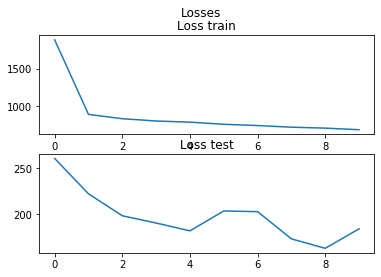

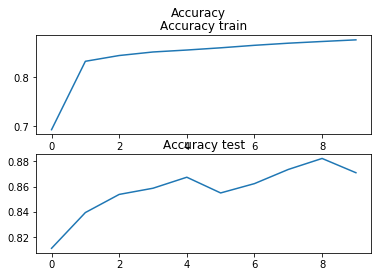

In [150]:
mod.fit(train_loader,test_loader, 10)

In [160]:
mod.predict_proba(test_loader).shape

torch.Size([12000, 10])